In [1]:
%load_ext watermark
%watermark

2019-06-13T11:46:00+02:00

CPython 3.6.8
IPython 6.2.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.13.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse
import warnings

%matplotlib inline
plt.rcParams['figure.figsize'] = (14,8)
warnings.filterwarnings('ignore')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [3]:
df_U_FR = pd.read_pickle('../Data/02.-Creacion-del-DataFrame-df_U_FR.pkl')

df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [4]:
df_U_FR.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [5]:
len(df_U_FR)

654

In [6]:
missing_dates = pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds'])

missing_dates

DatetimeIndex(['2017-06-24', '2017-12-25', '2018-01-01', '2018-01-06',
               '2018-07-21', '2018-07-22', '2018-07-28', '2018-11-01',
               '2018-11-02', '2018-11-03', '2018-11-04', '2018-11-05',
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-18', '2018-11-24',
               '2018-11-25', '2018-12-01', '2018-12-02', '2018-12-03',
               '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07',
               '2018-12-08', '2018-12-09', '2018-12-10', '2018-12-16',
               '2018-12-22', '2018-12-23', '2018-12-25', '2019-01-06',
               '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05',
               '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09',
               '2019-02-10', '2019-02-11', '2019-02-12'],
              dtype='datetime64[ns]', freq=None)

In [7]:
len(missing_dates)

47

In [8]:
def new_y_for_date(date,df_temp):
    df_monthdays_for_date = df_temp.loc[(df_temp['ds'].dt.year == date.year) &
                                        (df_temp['ds'].dt.month == date.month) &
                                        (df_temp['ds'].dt.weekday == date.weekday())]
    new_y = df_monthdays_for_date['y'].mean()
    if np.isnan(new_y) == False:
        return np.int64(round(new_y))
    else:
        return np.int64(round(df_temp.loc[df_temp['ds'].dt.weekday == date.weekday()]['y'].mean()))

In [9]:
df_missing_dates = pd.DataFrame()

df_missing_dates['ds'] = missing_dates

df_missing_dates['y'] = [new_y_for_date(date,df_U_FR) for date in df_missing_dates['ds']]

df_missing_dates.head()

,ds,y
0,2017-06-24,26
1,2017-12-25,4066
2,2018-01-01,2637
3,2018-01-06,39
4,2018-07-21,52


In [10]:
df_U_FR = df_U_FR.append(df_missing_dates)

df_U_FR['ds'] = pd.to_datetime(df_U_FR['ds'])

df_U_FR = df_U_FR.sort_values(by = 'ds')

df_U_FR = df_U_FR.reset_index(drop = True)

In [11]:
len(pd.date_range(start = '2017-05-01',end = '2019-04-01').difference(df_U_FR['ds']))

0

In [12]:
df_U_FR.head()

,ds,y
0,2017-05-01,48
1,2017-05-02,2371
2,2017-05-03,2640
3,2017-05-04,2565
4,2017-05-05,1717


In [13]:
df_U_FR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 2 columns):
ds    701 non-null datetime64[ns]
y     701 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.0 KB


In [14]:
len(df_U_FR)

701

In [15]:
df_train = df_U_FR.iloc[:641]

df_test = df_U_FR.iloc[641:]

In [16]:
df_test.head()

,ds,y
641,2019-02-01,1355
642,2019-02-02,11
643,2019-02-03,6
644,2019-02-04,2086
645,2019-02-05,2396


In [17]:
f = Prophet(seasonality_mode = 'multiplicative')
f.add_country_holidays(country_name = 'FRA')
f.fit(df_train)
df_temp = f.make_future_dataframe(periods = 60)
df_forecast = f.predict(df_temp)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


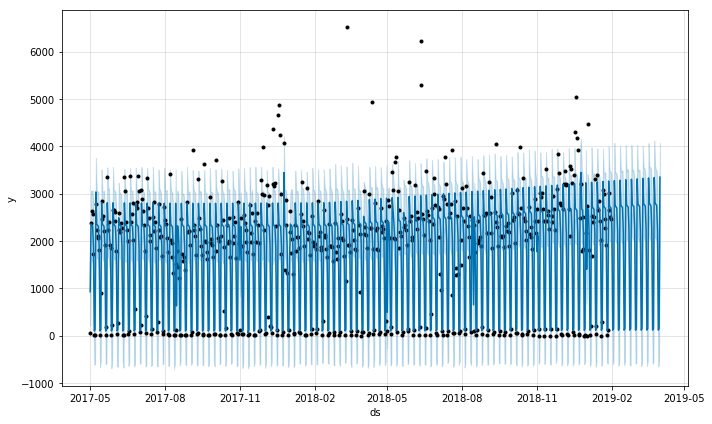

In [18]:
f.plot(df_forecast);

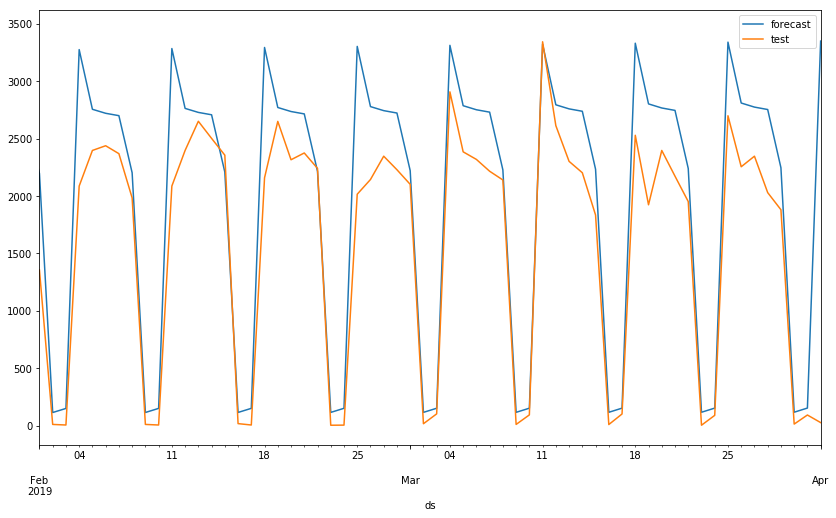

In [19]:
pd.plotting.register_matplotlib_converters()

ax = df_forecast.plot(x = 'ds',y = 'yhat',label = 'forecast',legend = True,figsize = (14,8));

df_test.plot(x = 'ds',y = 'y',
             label = 'test',
             legend = True,
             ax = ax,
             xlim = (pd.Timestamp('2019-02-01'),pd.Timestamp('2019-04-01')));

In [20]:
rmse(df_forecast.iloc[-60:]['yhat'],df_test['y'])

637.795057266577

In [21]:
def mape(y_pred,y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mape(df_forecast.iloc[-60:]['yhat'],df_test['y'])

583.8823459241218

In [23]:
df_forecast[df_forecast['ds'] >= '2019-02-01'][['ds','yhat']].head()

,ds,yhat
641,2019-02-01,2195.431266
642,2019-02-02,114.669290
643,2019-02-03,150.138203
644,2019-02-04,3273.836350
645,2019-02-05,2754.332498


In [24]:
df_test.head()

,ds,y
641,2019-02-01,1355
642,2019-02-02,11
643,2019-02-03,6
644,2019-02-04,2086
645,2019-02-05,2396


## Mejorar el modelo

## a) 

In [25]:
for i in [0.005,0.01,0.05,0.10,0.15,0.20,0.30,0.40,0.50,0.60,0.70,0.80,1]:
    f = Prophet(changepoint_prior_scale = i,seasonality_mode = 'multiplicative')
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.005 el MAPE es: 535.74


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.01 el MAPE es: 487.85


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.05 el MAPE es: 583.88


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.1 el MAPE es: 568.97


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.15 el MAPE es: 586.6


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.2 el MAPE es: 593.51


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.3 el MAPE es: 599.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.4 el MAPE es: 607.28


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.5 el MAPE es: 611.52


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.6 el MAPE es: 612.75


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.7 el MAPE es: 613.79


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Para un changepoint = 0.8 el MAPE es: 615.1
Para un changepoint = 1 el MAPE es: 612.05


## b)

In [26]:
for i in [0.005,0.01,0.05,0.10,0.15,0.20,0.30,0.40,0.50,0.60,0.70,0.80,1,2,3,4,5,6,7,8,9,10]:
    f = Prophet(seasonality_mode = 'multiplicative',
                changepoint_prior_scale = i,
                changepoint_range = 0.9,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

Para un changepoint = 0.005 el MAPE es: 491.88
Para un changepoint = 0.01 el MAPE es: 504.23
Para un changepoint = 0.05 el MAPE es: 570.56
Para un changepoint = 0.1 el MAPE es: 578.41
Para un changepoint = 0.15 el MAPE es: 590.43
Para un changepoint = 0.2 el MAPE es: 571.12
Para un changepoint = 0.3 el MAPE es: 527.72
Para un changepoint = 0.4 el MAPE es: 506.15
Para un changepoint = 0.5 el MAPE es: 491.68
Para un changepoint = 0.6 el MAPE es: 488.15
Para un changepoint = 0.7 el MAPE es: 481.23
Para un changepoint = 0.8 el MAPE es: 477.85
Para un changepoint = 1 el MAPE es: 469.5
Para un changepoint = 2 el MAPE es: 442.19
Para un changepoint = 3 el MAPE es: 437.2
Para un changepoint = 4 el MAPE es: 434.81
Para un changepoint = 5 el MAPE es: 430.89
Para un changepoint = 6 el MAPE es: 429.85
Para un changepoint = 7 el MAPE es: 430.01
Para un changepoint = 8 el MAPE es: 429.48
Para un changepoint = 9 el MAPE es: 427.7
Para un changepoint = 10 el MAPE es: 426.6


## c) 

In [27]:
for i in range(1,101):
    f = Prophet(seasonality_mode = 'multiplicative',
                changepoint_prior_scale = i,
                changepoint_range = 0.9,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

Para un changepoint = 1 el MAPE es: 469.5
Para un changepoint = 2 el MAPE es: 442.19
Para un changepoint = 3 el MAPE es: 437.2
Para un changepoint = 4 el MAPE es: 434.81
Para un changepoint = 5 el MAPE es: 430.89
Para un changepoint = 6 el MAPE es: 429.85
Para un changepoint = 7 el MAPE es: 430.01
Para un changepoint = 8 el MAPE es: 429.48
Para un changepoint = 9 el MAPE es: 427.7
Para un changepoint = 10 el MAPE es: 426.6
Para un changepoint = 11 el MAPE es: 426.32
Para un changepoint = 12 el MAPE es: 425.38
Para un changepoint = 13 el MAPE es: 425.1
Para un changepoint = 14 el MAPE es: 424.95
Para un changepoint = 15 el MAPE es: 426.32
Para un changepoint = 16 el MAPE es: 423.44
Para un changepoint = 17 el MAPE es: 424.31
Para un changepoint = 18 el MAPE es: 423.98
Para un changepoint = 19 el MAPE es: 424.27
Para un changepoint = 20 el MAPE es: 425.32
Para un changepoint = 21 el MAPE es: 425.14
Para un changepoint = 22 el MAPE es: 423.48
Para un changepoint = 23 el MAPE es: 424.86
Pa

## d) 

In [28]:
for i in range(1,51):
    f = Prophet(changepoint_prior_scale = i,
                changepoint_range = 0.9,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

Para un changepoint = 1 el MAPE es: 537.39
Para un changepoint = 2 el MAPE es: 464.68
Para un changepoint = 3 el MAPE es: 457.63
Para un changepoint = 4 el MAPE es: 460.59
Para un changepoint = 5 el MAPE es: 467.47
Para un changepoint = 6 el MAPE es: 473.23
Para un changepoint = 7 el MAPE es: 477.92
Para un changepoint = 8 el MAPE es: 486.86
Para un changepoint = 9 el MAPE es: 487.93
Para un changepoint = 10 el MAPE es: 493.93
Para un changepoint = 11 el MAPE es: 491.81
Para un changepoint = 12 el MAPE es: 491.01
Para un changepoint = 13 el MAPE es: 500.18
Para un changepoint = 14 el MAPE es: 501.45
Para un changepoint = 15 el MAPE es: 502.54
Para un changepoint = 16 el MAPE es: 512.39
Para un changepoint = 17 el MAPE es: 514.28
Para un changepoint = 18 el MAPE es: 500.88
Para un changepoint = 19 el MAPE es: 513.98
Para un changepoint = 20 el MAPE es: 509.77
Para un changepoint = 21 el MAPE es: 515.47
Para un changepoint = 22 el MAPE es: 515.69
Para un changepoint = 23 el MAPE es: 515.

## e) 

In [29]:
for i in [0.001,0.005,0.01,0.05,0.10,0.5,1]:
    f = Prophet(changepoint_prior_scale = i,
                changepoint_range = 0.9,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

Para un changepoint = 0.001 el MAPE es: 1203.57
Para un changepoint = 0.005 el MAPE es: 1014.86
Para un changepoint = 0.01 el MAPE es: 1026.82
Para un changepoint = 0.05 el MAPE es: 1205.43
Para un changepoint = 0.1 el MAPE es: 1247.85
Para un changepoint = 0.5 el MAPE es: 816.14
Para un changepoint = 1 el MAPE es: 537.39


## f) 

In [30]:
for i in [0.001,0.005,0.01,0.05,0.10,0.5,1]:
    f = Prophet(seasonality_mode = 'multiplicative',
                changepoint_prior_scale = i,
                changepoint_range = 0.9,
                yearly_seasonality = False,
                daily_seasonality = False)
    f.add_country_holidays(country_name = 'FRA')
    f.fit(df_train)
    df_temp = f.make_future_dataframe(periods = 60)
    df_forecast = f.predict(df_temp)
    print('Para un changepoint = {} el MAPE es: {}'.format(
        i,
        round(mape(df_forecast.iloc[-60:]['yhat'],df_test['y']),2)))

Para un changepoint = 0.001 el MAPE es: 7770.98
Para un changepoint = 0.005 el MAPE es: 491.88
Para un changepoint = 0.01 el MAPE es: 504.23
Para un changepoint = 0.05 el MAPE es: 570.56
Para un changepoint = 0.1 el MAPE es: 578.41
Para un changepoint = 0.5 el MAPE es: 491.68
Para un changepoint = 1 el MAPE es: 469.5
